# Homework 9 - Text Simplification as Machine Translation


## Total Points: 104 points
- **Overview**: In this homework assignment, you will learn about text simplification and will fine-tune GPT to translate complex English sentences into simple ones. We'll cover:

  - Exploring text completexity and how to measure it
  - Write simpler versions of sentences manually
  - Use prompting to simplify text with GPT
  - Fine-tune GPT to translate between complex and simple English

- **Grading**: We will use the auto-grading system called `PennGrader`. To complete the homework assignment, you should implement anything marked with `#TODO` and run the cell with `#PennGrader` note.


## Related Readings (Optional)

- [Simple-qe: Better automatic quality estimation for text simplification](https://arxiv.org/abs/2012.12382) Reno Kriz, Marianna Apidianaki, and Chris Callison-Burch, arXiv preprint arXiv:2012.12382, 2020.

- [Complexity-weighted loss and diverse reranking for sentence simplification](https://arxiv.org/abs/1904.02767) Reno Kriz, João Sedoc, Marianna Apidianaki, Carolina Zheng, Gaurav Kumar, Eleni Miltsakaki, and Chris Callison-Burch, arXiv preprint arXiv:1904.02767, 2019.

- [Simplification using paraphrases and context-based lexical substitution](https://aclanthology.org/N18-1019) Reno Kriz, Eleni Miltsakaki, Marianna Apidianaki, and Chris Callison-Burch, Proceedings of the 2018 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long Papers), pp. 207-217, 2018.

- [Optimizing statistical machine translation for text simplification](https://www.aclweb.org/anthology/Q16-1029) Wei Xu, Courtney Napoles, Ellie Pavlick, Quanze Chen, and Chris Callison-Burch, Transactions of the Association for Computational Linguistics 4, pp. 401-415, 2016.

- [Simple PPDB: A paraphrase database for simplification](https://aclanthology.org/P16-2024/) Ellie Pavlick, and Chris Callison-Burch, Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 2: Short Papers), pp. 143-148, 2016.

- [Problems in current text simplification research: New data can help](https://aclanthology.org/Q15-1021/) Wei Xu, Chris Callison-Burch, and Courtney Napoles, Transactions of the Association for Computational Linguistics 3, pp. 283-297, 2015.

## To get started, **make a copy** of this colab notebook into your google drive!

## PennGrader setup

In [ ]:
## DO NOT CHANGE ANYTHING, JUST RUN
%%capture
!pip install penngrader-client

In [ ]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

In [ ]:
!cat notebook-config.yaml

In [ ]:
from penngrader.grader import *

## TODO - Start
STUDENT_ID = 10101010 # YOUR PENN-ID GOES HERE AS AN INTEGER#
## TODO - End

SECRET = STUDENT_ID
grader = PennGrader('notebook-config.yaml', 'CIS5300_OL_23Su_HW9', STUDENT_ID, SECRET)

In [ ]:
# check if the PennGrader is set up correctly
# do not change this cell, see if you get 4/4!
name_str = 'CIS 5300 Student'
grader.grade(test_case_id = 'name_test', answer = name_str)

# Section 1: Exploring Text Complexity
**Background:** Text simplification is the process of converting complex sentences into simple ones that are still faithful to the originl meaning. It can be used in cases where a complex document needs to be translated into a simpler form for a particular audience, like children, non-native speakers, and people who face reading difficulties. Even computational tasks like machine translation and text summarization can benefit from simplifying text first.

Over the years, research on text simplification has evolved from simple, rule-based approaches like substituting complex words with simpler ones, or splitting long sentences into more easily understandable shorter ones, to more complex methods that leverage large language models to understand complex pieces of information and generate simpler versions.

Here, we will attempt and evaluate different methods and finally use modern techniques like fine-tuning GPT to "translate" complex text into simple text.

First, let's install and import the required libraries.

In [ ]:
%%capture
!pip install openai textstat nltk pandas jsonlines wandb scikit-learn

import os
from openai import OpenAI
import textstat
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import pandas as pd
from random import sample
import numpy as np
import json
import time
import seaborn as sns
import string
import glob
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
%%capture
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

In [ ]:
from getpass import getpass
import os

print('Enter OpenAI API key:')
openai_api_key = getpass()

os.environ['OPENAI_API_KEY']=openai_api_key
client = OpenAI()

### What makes a sentence simple?

**Problem 1.1**

Before we use computers to perform this task, let's first try to do it ourselves to understand it better. Pick five complex sentences you may have recently read (or find some on the Internet), and write your own simplified versions of them.

Example:

In [ ]:
original_sentence = "The diversification in occupational roles has become a crucial attribute in today's rapidly evolving job market."

simplified_sentence = "Having a variety of job roles is important for today's fast-changing job market."

example_sentence_pair = (original_sentence, simplified_sentence)

In [ ]:
# TODO


##################################################

pair_1 = None
pair_2 = None
pair_3 = None
pair_4 = None
pair_5 = None

##################################################

pairs = [pair_1, pair_2, pair_3, pair_4, pair_5]

In [ ]:
grader.grade(test_case_id = 'test_five_sentences', answer = pairs)

**Problem 1.2**

After completing the above task, list five general changes (not specifically to the pairs above) that you might make to a complex sentence to transform it into a simpler one. Your answers should be included in your separate "***writeup.pdf***" file and will be manually graded (5 points).

In [ ]:
# TODO in writeup.pdf file


### Measuring complexity

While it may be clear to you that the transformed sentences are simpler than the original ones, we need a way to quanitify this so that we can automate the process.

One way to think about this is to measure the 'readability' of a text. The most well-known readability metric are the Flesch–Kincaid tests. The test have two types: Flesch Reading-Ease and Flesch–Kincaid Grade Level.

The Flesch Reading-Ease test is scored on a scale of 1-100, with higher scores indicating that the text is easier to read. The score is calculated by the following formula:

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/bd4916e193d2f96fa3b74ee258aaa6fe242e110e)


The table below shows a breakdown of the different levels and how they translate to school levels.


| Score | School level (US) | Notes                                                           |
|-------|------------------|-----------------------------------------------------------------|
| 100.00–90.00 | 5th grade  | Very easy to read. Easily understood by an average 11-year-old student. |
| 90.0–80.0 | 6th grade | Easy to read. Conversational English for consumers.                   |
| 80.0–70.0 | 7th grade | Fairly easy to read.                                                |
| 70.0–60.0 | 8th & 9th grade | Plain English. Easily understood by 13- to 15-year-old students.  |
| 60.0–50.0 | 10th to 12th grade | Fairly difficult to read.                                      |
| 50.0–30.0 | College | Difficult to read.                                                 |
| 30.0–10.0 | College graduate | Very difficult to read. Best understood by university graduates. |
| 10.0–0.0 | Professional | Extremely difficult to read. Best understood by university graduates. |

\
The Flesch–Kincaid Grade Level, on the other hand, calculates the approximate U.S. grade level that corresponds to the complexity of the given text. It is therefore inversely related to the Flesch Reading-Ease, since lower school grade levels correspond to text that is easier to read, and provides a more interpretable understanding of the complexity of a text. It is calculated by the following formula:

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/8e68f5fc959d052d1123b85758065afecc4150c3)

Notice how, in both tests, having more words per sentence, and having more syllables per word, both increase the complexity of text.

**Problem 1.3**

Using the appropriate functions in the `textstat` module, evaluate the complexity of your sentences and confirm that the simplified ones score accordingly on both metrics. You can find the documentation for it [here](https://github.com/textstat/textstat). Look for functions that measure the **Flesch Reading-Ease** and **Flesch–Kincaid Grade Level**.

Your solution should be formatted as follows:

```
reading_ease = [(pair1_complex_sentence_score, pair1_simple_sentence_score), ...]
grade_level = [(pair1_complex_sentence_score, pair1_simple_sentence_score), ...]
```


In [ ]:
# TODO

reading_ease = None
grade_level = None

##################################################


##################################################

In [ ]:
grader.grade(test_case_id = 'test_compare_complexity', answer = (reading_ease, grade_level, pairs))

## Evaluating simplification quality

While measuring the change in Flesch-Kincaid Grade Level is one measure of how good a simplification is, another way to measure its quality is to see how faithful it is to the original sentence. While we want the simplification to be concise, we also want it to retain the meaning of the original.

### Measuring semantic similarity

In order to measure the similarity of two sentences, we can compute the difference between their vector embeddings. We studied word embeddings earlier in the class, which let us represent words as vectors we can use to compute how similar two words are to each other. The same can be done for sentences, and even documents, using large language models (LLMs). Let's see how this works.

**Problem 1.4**

Define a function that gets the embeddings for a given piece of text from the OpenAI API. Use the `text-embedding-ada-002` model, which accepts a list of strings as input and returns a list embeddings in response. You can look at the API documentation [here](https://platform.openai.com/docs/guides/embeddings/use-cases).

In [ ]:
# TODO

def get_embedding(text, model="text-embedding-ada-002"):

  embeddings = None

  ##################################################

  ##################################################

  return embeddings

embeddings = [(get_embedding(i), get_embedding(j)) for (i, j) in pairs]

In [ ]:
grader.grade(test_case_id = 'test_embeddings', answer = (embeddings, pairs, openai_api_key))

**Problem 1.5**

Now use the cosine similarity function we imported from `scikit-learn` to compare the embeddings of all pairs of sentences. You can read its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html).

Completely identical sentences should have a similarity of 1.0, while sentences roughly on the same topic might have a cosine similarity of 0.9. Ideally, we want our simplified sentences to be as close to their original, complex versions as possible.

In [ ]:
# TODO

sim = None

##################################################


##################################################

In [ ]:
grader.grade(test_case_id = 'test_compute_sim', answer = (sim, embeddings, openai_api_key))

# Section 2: Rule-based Simplification

Given what we have learned from the above exercise, let's now try to write a simple rule-based system for simplifying sentences.

One of the ways to simplify a sentence is to use simpler words in the place of complex ones. Use the wordnet lexical database to replace complex words in a sentence with their synonyms that are simpler. Some heuristics you might want to consider are the word length, number of syllables, and frequency in the English corpus.

**Problem 2.1**

Using WordNet, list all the synonyms of the following words:
language, research, complex, simple, model. Your answer should be a list of length five, where each element is an alphabetically sorted list containing all the synonyms of the respective word.


```
[
  ['word1_synonym1', 'word1_synonym2', ... ],
  ['word2_synonym1', 'word2_synonym2', ... ],
  ...
]
```


You can see the NLTK WordNet documentation [here](https://www.nltk.org/howto/wordnet.html).


In [ ]:
# TODO
words = ['language', 'research', 'complex', 'simple', 'model']

def get_synonyms(word):

  synonyms = None

  ##################################################


  ##################################################


  return synonyms

synonyms = [get_synonyms(word) for word in words]

In [ ]:
grader.grade(test_case_id = 'test_synonyms', answer = (synonyms))

Once we have a list of possible replacements for a word, we need a way to pick the simplest one. One heuristic for this is how common a word is in the English language -- common words tend to be simpler than rare ones. To get the frequency of a word, you can use the Google n-grams corpus from your text classification homework.

Let's download and unzip the Google n-gram dataset first.

In [ ]:
!curl -L -o ngram_counts.txt.gz http://www.cis.upenn.edu/~cis5300/18sp/data/ngram_counts.txt.gz

In [ ]:
!gzip -d ngram_counts.txt.gz

**Problem 2.2**

Write a function to extract the frequency of a given word from the n-gram dataset. It might help to store the n-grams in a data structure that allows efficient retrieval. You should return the frequency as an integer. If a word does not appear in the n-gram dataset, its frequency should be 0.

In [ ]:
# TODO

##################################################

##################################################

freqs = [get_freq(word) for word in words]

In [ ]:
grader.grade(test_case_id = 'test_word_freq', answer = freqs)

**Problem 2.3**

Now put both of these pieces together to write a function that, given a sentence, replaces each word with its simplest i.e. most common synonym. You will find all possible synonyms for each word in the sentence and replace them with the most frequently occuring one.

Example input: Science is a subject that requires meticulous attention to detail and rigorous experimentation

Example output: Science be a case that take meticulous care to point and strict experiment

In [ ]:
# TODO

def synonym_simplify(text):

  output = None

  ##################################################


  ##################################################

  return output

simplified = synonym_simplify("The diversification in occupational roles has become a crucial attribute in today's rapidly evolving job market")

In [ ]:
grader.grade(test_case_id = 'test_synonym_simplify', answer = simplified)

# Section 3: Simplification via Prompting

Since you have seen that simplification is a hard task to do using hard-coded rules, let's try using large language models to simplify text for us. We will use GPT-4o-mini for this task.

## Zero-shot

In zero-shot prompting, we simply give the model a piece of input, called a prompt, which may contain a question or instruction, and ask the model to process it and return an output.


**Problem 3.1**

Write a prompt that asks GPT to simplify a given sentence. The input (complex) sentence will be appended to the end of the prompt. In response, GPT should return the resulting (simple) sentence.

In [ ]:
# TODO

def simplify_zeroshot(prompt, sentence):

  messages = [
        {"role": "user", "content": prompt + sentence},  # appending the sentence to the prompt
  ]

  response = client.chat.completions.create(
      model="gpt-4o-mini",
      messages=messages,
      temperature=0.7,
      max_tokens=256,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      # stop=["\n"]
  )

  # We recommend putting a short wait after each call,
  # since the rate limit for the platform is 60 requests/min.
  # (This increases to 3000 requests/min after you've been using the platform for 2 days).
  time.sleep(1)

  # the response from OpenAI's API is a JSON object that contains
  # the completion to your prompt plus some other information. Here's how to access
  # just the text of the completion.
  return response.choices[0].message.content.strip()

##################################################
prompt = None
##################################################

simplify_zeroshot(prompt, original_sentence)

Here is some information about the different arguments that we gave to the `client.completions.create` call:
 * `model` – Model ID used to generate the response, like gpt-4o or gpt-4o-mini, which we use here.
 * `messages` - A list of messages comprising the conversation so far.
 * `temperature` - controls how much of the probability distribution the model will use when it is generating each token. 1.0 means that it samples from the complete probability distrubiton, 0.7 means that it drops the bottom 30% of the least likely tokens when it is sampling. 0.0 means that it will perform deterministically and always output the single most probable token for each context.
 * `top_p` - is an alternative way of controling the sampling.
 * `frequency_penalty` and `presence_penalty` are two ways of reduing the model from repeating the same words in one output.  You can set these to be >0 if you're seeing a lot of repetition in your output.
 * `max_tokens` is the maximum length in tokens that will be output by calling the function.  A token is a subword unit.  There are roughly 2 or 3 tokens per word on average.
 * `stop` is a list of stop sequences.  The model will stop generating output once it generates one of these strings, even if it hasn't reached the max token length. By default this is set to a special token `<|endoftext|>`.

You can read more about [the Chat Completions API call in the documentation](https://platform.openai.com/docs/api-reference/chat).

In [ ]:
grader.grade(test_case_id = 'test_zeroshot', answer = (openai_api_key, prompt))

Try this prompt on all five of your complex sentences and calculate the readibility metrics on both the simplified forms. Confirm that the simplified sentences are more readable than the originals, and compare the level of simplification performed by GPT against your manual attempt.

In [ ]:
simple_sentences_gpt = [simplify_zeroshot(prompt, i) for i, j in pairs]
simple_sentences_gpt

**Problem 3.2**

You can also vary how much you want GPT to simplify a sentence. Write two prompts, one which simplifies the input sentence a little, and another which simplifies the input sentence comparatively more.

You can try doing this at different levels and check whether the Flesch-Kincaid scores change accordingly.


In [ ]:
# TODO

##################################################
prompt_less_simple = None
prompt_more_simple = None
##################################################

print(simplify_zeroshot(prompt_less_simple, original_sentence))
print(simplify_zeroshot(prompt_more_simple, original_sentence))

In [ ]:
grader.grade(test_case_id = 'test_zeroshot_levels', answer = (openai_api_key, prompt_less_simple, prompt_more_simple))

You can also give GPT specific instructions on how it should simplify a sentence. Try writing prompts explicitly instructing GPT to make the specific changes you listed above in Problem 1.2 and see whether that works.

In [ ]:
##################################################
prompt_change_1 = None
##################################################

print(simplify_zeroshot(prompt_change_1, original_sentence))

## Few-shot

One way to make GPT do a better job at a task is to give it a few examples describing what we want instead of just giving it an instruction. We can do this by providing a few pairs of complex and simple sentences (in that order, and separated by a hypen) in the prompt, and GPT will learn the mapping between them. We can then give it the target complex sentence as part the prompt (followed by a hyphen), and GPT will complete it by responding with its simplified version.

```
"""
complex_sentence_1 - simple_sentence_1
complex_sentence_2 - simple_sentence_2
...
complex_sentence_5 -
"""
```

**Problem 3.3**

Write a prompt in the above format (minus the last sentence) that uses the first four of your sentences as few-shot examples.

In [ ]:
# TODO

def simplify_fewshot(prompt, sentence):

  prompt = f"{prompt.strip()}\n{sentence} - "  # appending the sentence to the prompt

  messages = [
        {"role": "user", "content": prompt},
  ]

  response = client.chat.completions.create(
      model="gpt-4o-mini",
      messages=messages,
      temperature=0.7,
      max_tokens=256,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      stop=["\n"]
  )
  time.sleep(1)

  return response.choices[0].message.content.strip()

prompt = None

##################################################


##################################################

simplify_fewshot(prompt, pairs[-1][0])

In [ ]:
grader.grade(test_case_id = 'test_fewshot', answer = (openai_api_key, prompt, pairs))

# Section 4: Fine-tuning

In addition to zero-shot and few-shot learning, another way of getting large language models to do your tasks is via a process called "fine tuning".  In fine-tuning the model updates its parameters so that it performs well on many training examples.  The training examples are in the form of original complex sentences paired with their gold standard simplified forms.

Large language models are pre-trained to perform well on general tasks like text completion but not on the specific task that you might be interested in.  The models can be fine tuned to perform you task, starting with the model parameters that are good for the general setting, and then updating them to be good for your task.

We'll walk through how to fine-tune GPT for text simplification.


### Data

We'll be using the Newsela dataset (Xu et. al., 2015). This dataset contains sentences from news articles that have been simplified at 4 different grade levels for different audiences.

In [ ]:
!gdown 10HX4ekdQdDyZyTldtj0qfly437B9cL5C

In [ ]:
!unzip newsela-auto.zip

In [ ]:
%%capture
sentences_df = pd.read_csv('newsela-auto/newsela-auto/all_data/aligned-sentence-pairs-all.tsv', sep='\t', names=['id_simple', 'completion', 'id_complex', 'prompt'], on_bad_lines='warn')
sentences_df = sentences_df[sentences_df['prompt'].str.len() > 50]

In [ ]:
sentences_df

The sentences are provided at five levels of simplicity, numbered [0-4], where 0 denotes the original, complex sentence, and 4 denotes its simplest form.

As you see above, each line contains the id of the sentence, which also contains this simplicity marker.

In `brain-gender.en-1-4-0`, its simplicity level is 1.

In `bbking-obit.en-4-21-0`, its simplicity level is 4.

### Select a subset of the data for fine-tuning

**Problem 4.1**

Keep only the rows with the most complex prompts (i.e. their simplicity level is 0) simplest completions (i.e. their simplicity level is 4). Then randomly sample 100 sentences from the dataframe (use the random_state value given above).

Your solution should be a dataframe with 100 rows and the same 4 columns as above.

In [ ]:
random_state = 42
num_sample = 100

In [ ]:
# TODO

sentences_df_sample = None

##################################################

##################################################

In [ ]:
sentences_df_sample

In [ ]:
grader.grade(test_case_id = 'test_newsela_sample', answer = (sentences_df_sample.iloc[0]['id_simple'], sentences_df_sample.iloc[-1]['id_complex']))

## Format data for fine-tuning

Below, we'll format data to fine-tune GPT.  The OpenAI API documentation has a [guide to fine-tuning models](https://platform.openai.com/docs/guides/fine-tuning) that you should read.   The basic format of fine-tuning data is a JSONL file (one JSON object per line) with each example in the dataset should be a conversation in the same format as the Chat Completions API, specifically a list of messages where each message has a role and content.

```
{"messages": [{"role": "user", "content": "<prompt text>"}, {"role": "assistant", "content": "<ideal generated text>"}]}
{"messages": [{"role": "user", "content": "<prompt text>"}, {"role": "assistant", "content": "<ideal generated text>"}]}
{"messages": [{"role": "user", "content": "<prompt text>"}, {"role": "assistant", "content": "<ideal generated text>"}]}
...
```

Where our complex sentences form the `<prompt_text>` and the simplified sentences are the `<ideal generated text>`

Do NOT use `system` messages when constucting the messages for your document, this is for the autograder

**Problem 4.2**

Format the dataframe you created above in the JSON format and write it in a file with the name defined below.

In [ ]:
fine_tuning_sentences_filename = 'newsela_sentences_finetuning_data.jsonl'

In [ ]:
# TODO

##################################################


##################################################


In [ ]:
with open(fine_tuning_sentences_filename) as f:
  newsela_json = f.read().strip().split('\n')

In [ ]:
grader.grade(test_case_id = 'test_newsela_json', answer = (newsela_json[0], newsela_json[-1]))

You can verify that the file looks okay by printing out the first ten lines:

In [ ]:
!head {fine_tuning_sentences_filename}

You can also count the total number of lines, words, and characters in the file:

In [ ]:
!wc {fine_tuning_sentences_filename}

## Run the fine-tuning API

Next, we'll make the fine tuning call via the python library. There are 2 sizes of GPT-4 models. They go in alphabetical order from largest to smallest:

*   `gpt-4o-2024-08-06`
*   `gpt-4o-mini-2024-07-18`

As the model sizes increase, so does their quality and their cost. `gpt-4o` is the highest quality and highest cost model. We recommend starting by fine-tuning smaller models to debug your code first so that you don't rack up costs. Once you're sure that your code is working as expected then you can fine-tune a `gpt-4o` model, although `gpt-4o-mini` is perfectly capable and recommended based on the price.

The size of the dataset we've created has been chosen so as to not be too expensive for you to fine-tune your models on and should only cost a few dollars. We encourage experimenting with the simpler, cheaper models before using the more capable and expensive ones.

**Problem 4.3**

Run the fine-tuning API to create your fine-tuned model. You can read the documentation [here](https://platform.openai.com/docs/guides/fine-tuning/create-a-fine-tuned-model).

You may validate your training file, if you would like, using the script in this [link](https://cookbook.openai.com/examples/chat_finetuning_data_prep).

Although, this is NOT required.

Once you have the dataset created, the file needs to be uploaded using the Files API in order to be used with a fine-tuning jobs:

In [ ]:
##################################################

fine_tuning_file_id = None
##################################################

After ensuring you have uploaded the file, the next step is to create a fine-tuning job.

In [ ]:
##################################################

fine_tuning_job_id = None
##################################################

You may monitor the status of your fine-tuning job using the below code:

In [ ]:
response = client.fine_tuning.jobs.list_events(fine_tuning_job_id)

events = response.data
events.reverse()

for event in events:
    print(event.message)


Once your fine-tune is completed, you should see a message in the output of the above code saying   
`The job has successfully completed`.

In [ ]:
# you may also check the status of your fine-tuning job in the UI using this link
print(f"https://platform.openai.com/finetune/{fine_tuning_job_id}")

You can retrieve your model ID, by running this command

In [ ]:
# prints your fine-tuned model ID
client.fine_tuning.jobs.retrieve(fine_tuning_job_id).fine_tuned_model

The above output will contain the ID of your model, which you should should copy down for use later. It will look something like this:

```
ft:gpt-4o-mini-2024-07-18:university-of-pennsylvania::BBYu06Qj
```

If you forget to write it down, you can list your fine-tuned runs and models with the following command:

In [ ]:
client.fine_tuning.jobs.list(limit=10)

In [ ]:
fine_tuned_model = 'model_ID' # replace with your REAL ft-model ID from above

In [ ]:
grader.grade(test_case_id = 'test_finetune_created', answer = (openai_api_key, fine_tuned_model))

## Test your fine-tuned model

**Problem 4.4**

Write a function that uses your fine-tuned model to generate simplified sentences. The function will look the same as the zeroshot example above, except that you will provide a prompt but instead the specific model ID of your fine-tuned model to use instead of OpenAI's default models.

In [ ]:
# TODO

def generate_simple_sentence(complex_sentence, finetuned_model):

  response = None

  ##################################################

  ##################################################

  return response.choices[0].message.content.strip()

finetuned_model = "model_ID" # remember to replace this with your own model ID

fine_tune_test = generate_simple_sentence(original_sentence, finetuned_model)

In [ ]:
grader.grade(test_case_id = 'test_finetune_eval', answer = (openai_api_key, fine_tune_test, original_sentence))

# Section 5: Instruction Fine-tuning

In this section, we'll try simplifying whole documents instead of sentences. We'll also instruct GPT to simplify a given document to a particular degree.


### Data

We'll again be using the Newsela dataset (Xu et. al., 2015), but this time a different versions which contains the whole documents instead of individual sentences. Let's start by downloading the data.

In [ ]:
!gdown 1ozFO2juiYmpOsLUVzI1awyyS86PlbBDz

In [ ]:
%%capture
!unzip newsela_share_2020.zip

In [ ]:
article_list = pd.read_csv('newsela_share_2020/documents/articles_metadata.csv')

In [ ]:
article_list

If we look at the file `articles_metadata.csv` in the documents folder, we see that it has a list of the articles and their title, language, grade level, and filename. We can use this spreadsheet to select a subset of articles to finetune our model on.

Notice how there are 5 versions of each article, where the version number [0-5] corresponds to the grade level [12, 8, 6, 5, 3], with higher version numbers representing increasingly simple versions of the article.

## Analyzing readibility, text length, and vocabulary

Let's look at how text readibility correlates with the length of a document and its sentences. We'll also take a look at the top words for simple and complex documents. You won't have to implement anything in here, this is just to show you how complex and simple documents differ along different dimensions.

In [ ]:
article_path = 'newsela_share_2020/documents/articles/'
files_complex = glob.glob(article_path+'*.en.0.txt')
files_simple = glob.glob(article_path+'*.en.4.txt')

In [ ]:
articles = []

for fname in files_complex+files_simple:
  with open(fname) as f:
    if fname.endswith('.en.0.txt'):
      articles.append([f.read().strip(), 'complex', fname.split('/')[-1]])
    else:
      articles.append([f.read().strip(), 'simple', fname.split('/')[-1]])

articles_df = pd.DataFrame(articles, columns=['text', 'type', 'filename'])

In [ ]:
articles_df['readibility'] = articles_df['text'].apply(textstat.flesch_reading_ease)
articles_df['length'] = articles_df['text'].apply(lambda x: len(x.split()))
articles_df['sent_length'] = articles_df['text'].apply(lambda x: np.mean([len(i.split()) for i in x.split('.')]))
articles_df = articles_df.sort_values(by='length')[:-1]

### Readibilty vs. document length

Note how long documents tend to be less readible than short ones because they may contain more detail.

In [ ]:
sns.regplot(data=articles_df, x='readibility', y='length')

### Readibility vs. average sentence length
Similarly, longer sentences also tend to be less readible than shorter ones because they can be hard to parse for a reader.

<Axes: xlabel='readibility', ylabel='sent_length'>

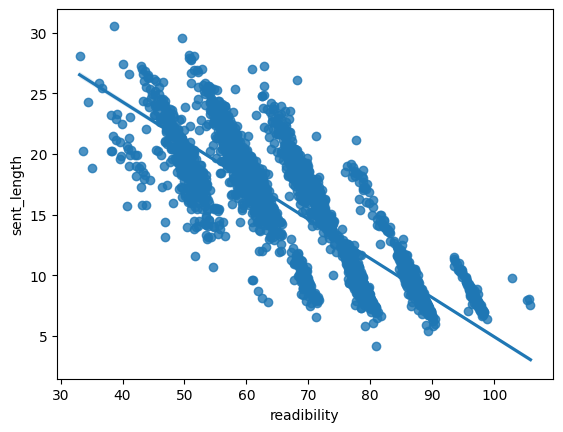

In [ ]:
sns.regplot(data=articles_df, x='readibility', y='sent_length')

### Comparing word frequencies in simple documents vs complex documents

Let's look at which words are most overrepresented in each class of document. First we'll count the frequencies of all words and calculate their unigram probabilities per class. Then we'll filter them to keep only words which exist in the English language. Finally, for words that appear in both classes, we'll divide their frequencies to find the most over-represented words in each class.

In [ ]:
complex_articles = ' '.join(articles_df[articles_df.filename.str.contains('.en.0.txt')].text.to_list())
simple_articles = ' '.join(articles_df[articles_df.filename.str.contains('.en.4.txt')].text.to_list())

complex_articles =  complex_articles.translate(str.maketrans('', '', string.punctuation)).lower()
simple_articles =  simple_articles.translate(str.maketrans('', '', string.punctuation)).lower()

complex_words = Counter(complex_articles.split())
simple_words = Counter(simple_articles.split())

sw = set(stopwords.words('english'))

complex_words = {w:f for w, f in complex_words.items() if wn.synsets(w) and w not in sw}
simple_words = {w:f for w, f in simple_words.items() if wn.synsets(w) and w not in sw}

total_complex = sum(complex_words.values())
total_simple = sum(simple_words.values())

for word in complex_words:
  complex_words[word] /= total_complex
for word in simple_words:
  simple_words[word] /= total_simple

odds_ratio = {}

for word in complex_words:
  if word in simple_words:
    odds_ratio[word] = complex_words[word] / simple_words[word]


In [ ]:
odds_ratio = sorted(odds_ratio.items(), key=lambda x: x[1], reverse=True)

Top words in complex documents:

In [ ]:
odds_ratio[:10]

[('advocates', 110.62421223546247),
 ('status', 93.21114179099153),
 ('additional', 92.18684352955206),
 ('colleagues', 79.89526439227845),
 ('facilities', 73.74947482364166),
 ('potential', 57.53141901751675),
 ('investment', 57.36070264061017),
 ('cited', 54.28780785629177),
 ('legacy', 53.2635095948523),
 ('acknowledged', 49.16631654909444)]

Top words in simple documents:

In [ ]:
odds_ratio[-10:]

[('unfairly', 0.09455060874825853),
 ('grownups', 0.08535818845328896),
 ('dishonest', 0.08535818845328895),
 ('pretended', 0.08535818845328895),
 ('cleans', 0.08535818845328895),
 ('shiites', 0.07879217395688211),
 ('cheated', 0.07879217395688211),
 ('primaries', 0.03658208076569527),
 ('gasses', 0.03658208076569527),
 ('disagrees', 0.021339547113322237)]

Notice how the words most commonly found in complex documents are, naturally, more complex and formal than the words found in the simple documents. This minor differences add up at the document level to increase an article's complexity.

## Select a subset of the data for fine-tuning

**Problem 5.1**

Keep only English articles for which we have the 5 levels of complexity [0-4], from the most complex (version number 0) to the least complex (version number 4). Then select the 10 slugs which have the shortest original/complex documents (version 0) and keep all versions [0-4] of their documents. Your solution should have 50 total rows in this dataframe (10 slugs x 5 levels per article), with the same 6 columns as the original article metadata file.

In [ ]:
random_state = 42
num_sample = 100

In [ ]:
# TODO

article_list_filtered = None

##################################################

##################################################

document_df_sample = article_list_filtered


In [ ]:
grader.grade(test_case_id = 'test_documents_sample', answer = (document_df_sample.iloc[0]['slug'], document_df_sample.iloc[-1]['filename']))

## Format data for fine-tuning

Below, we'll format data to fine-tune GPT. Instead of just providing the complex document as the prompt and the simple document as the completion text, we'll add an instruction within the prompt to tell GPT to simplify the document to the particular grade level of the completion text as follows:

```

{"messages": [{"role": "user", "content": "Simplify this document for a student of grade 6: <grade 12 text>"}, {"role": "assistant", "content": "<grade 6 text>"}]}
{"messages": [{"role": "user", "content": "Simplify this document for a student of grade 3: <grade 12 text>"}, {"role": "assistant", "content": "<grade 3 text>"}]}
{"messages": [{"role": "user", "content": "Simplify this document for a student of grade 5: <grade 12 text>"}, {"role": "assistant", "content": "<grade 5 text>"}]}
...
```

Where our complex sentences form the `<grade 12 text>` and the simplified sentences are the `<grade 4/5/6/8 text>`.

Make sure you fine-tuning dataset follows the above format exactly, the autograder expects the `Simplify this document for a student of grade ` part.

Also, as before, we do NOT use `system` messages here.

**Problem 5.2**

Use the dataframe you created above to create a fine-tuning dataset and write a JSON file in the above format with the name defined below. Note that since all prompts will be grade 12 documents and all completions will be grade 4/5/6/8 documents, this file will contain 40 documents in total. Use a mapping of version to grade:

```
{
    grade 8: version 1
    grade 6: version 2
    grade 5: version 3
    grade 4: version 4
}
```

Remember to remove any leading or trailing spaces in the documents.

In [ ]:
fine_tuning_documents_filename = 'newsela_documents_finetuning_data.jsonl'

In [ ]:
# TODO

##################################################

##################################################


In [ ]:
with open(fine_tuning_documents_filename) as f:
  documents_json = f.read().strip().split('\n')

In [ ]:
grader.grade(test_case_id = 'test_documents_json', answer = (documents_json[0], documents_json[-1]))

In [ ]:
!head '{fine_tuning_documents_filename}'

In [ ]:
!wc '{fine_tuning_documents_filename}'

## Run the fine-tuning API

**Problem 5.3**

Run the fine-tuning API to create your fine-tuned model. You can read the documentation [here](https://platform.openai.com/docs/guides/fine-tuning/create-a-fine-tuned-model).

You may validate your training file, if you would like, using the script in this [link](https://cookbook.openai.com/examples/chat_finetuning_data_prep).

Although, this is NOT required.

Once you have the data validated, the file needs to be uploaded using the Files API in order to be used with a fine-tuning jobs:

In [ ]:
##################################################

fine_tuning_file_id = None
##################################################

After ensuring you have uploaded the file, the next step is to create a fine-tuning job.

In [ ]:
##################################################

fine_tuning_job_id = None
##################################################

You may monitor the status of your fine-tuning job using the below code:

In [ ]:
response = client.fine_tuning.jobs.list_events(fine_tuning_job_id)

events = response.data
events.reverse()

for event in events:
    print(event.message)


Once your fine-tune is completed, you should see a message in the output of the above code saying   
`The job has successfully completed`.

In [ ]:
# you may also check the status of your fine-tuning job in the UI using this link
print(f"https://platform.openai.com/finetune/{fine_tuning_job_id}")

You can retrieve your model ID, by running this command

In [ ]:
# prints your fine-tuned model ID
client.fine_tuning.jobs.retrieve(fine_tuning_job_id).fine_tuned_model

The above output will contain the ID of your model, which you should should copy down for use later. It will look something like this:

```
ft:gpt-4o-mini-2024-07-18:university-of-pennsylvania::BBYu06Qj
```

If you forget to write it down, you can list your fine-tuned runs and models with the following command:

In [ ]:
client.fine_tuning.jobs.list(limit=10)

In [ ]:
fine_tuned_model_doc = 'model_ID' # replace with your REAL ft-model ID from above

In [ ]:
grader.grade(test_case_id = 'test_finetune_doc_created', answer = (openai_api_key, fine_tuned_model_doc))

## Test your fine-tuned model

**Problem 5.4**

Use your fine-tuned model to generate simplified sentences.

In [ ]:
# TODO

def generate_simple_documents(complex_document, instruction_prompt, finetuned_model):

  response = None

  ##################################################

  ##################################################

  return response.choices[0].message.content.strip()

finetuned_model_doc = "model_ID" # replace with your REAL ft-model ID from above
instruction_prompt = 'Simplify this document for a student of grade 1:'

fine_tune_test_doc = generate_simple_documents(original_sentence, instruction_prompt, finetuned_model_doc)

In [ ]:
grader.grade(test_case_id = 'test_finetune_doc_eval', answer = (openai_api_key, fine_tune_test_doc, original_sentence))

Now that we have finetuned a new model to simplify documents, we can test it out in the same manner as before.

# Section 6: Evaluation

In this section, you will attempt to evaluate how well each of the models you built (zeroshot, fewshot, finetuning) perform at this task. You will do a series of evaluations for 10 random sentences where you will be presented with two completions for a sentence and asked to pick which is better. Your responses will decide which model wins the most out of all three. Finally, you will write your thoughts about what you learned from this exercise at the end.

In [ ]:
input_sentences = pd.DataFrame(sentences_df.sample(10, random_state=random_state).prompt).reset_index().drop(columns=['index'])

In [ ]:
# TODO

##################################################

zeroshot_prompt = None
fewshot_prompt = None
fine_tuned_model = None # use your model ID from section 4

##################################################

input_sentences['completion_1'] = input_sentences['prompt'].apply(lambda x: simplify_zeroshot(zeroshot_prompt, x))
input_sentences['completion_2'] = input_sentences['prompt'].apply(lambda x: simplify_fewshot(fewshot_prompt, x))
input_sentences['completion_3'] = input_sentences['prompt'].apply(lambda x: generate_simple_sentence(x, fine_tuned_model))


In [ ]:
ratings = {1:0, 2:0, 3:0}
annot = []

for index, row in input_sentences.iterrows():
  s1, s2 = 1, 2
  for i in range(1,4):
    if i == 2:
      s1, s2 = 2, 3
    elif i == 3:
      s1, s2 = 1, 3

    print('-'*50)
    print(f'\nTask {index*3+i} of 30')
    print('Original sentence:\t', row['prompt'])
    print('Simplification 1:\t', row['completion_'+str(s1)])
    print('Simplification 2:\t', row['completion_'+str(s2)])
    r = int(input('Which simplification is better? Enter 1 or 2: '))
    if i == 1:
      ratings[r]+=1
    if i == 2:
      ratings[r+1]+=1
    elif i == 3:
      if r == 1:
        ratings[1]+=1
      else:
        ratings[3]+=1
    annot.append((row['prompt'], row['completion_'+str(s1)], row['completion_'+str(s2)], r))

annot_df = pd.DataFrame(annot, columns=['input', 'simplification_1', 'simplification_2', 'choice'])
annot_df.to_csv('human_eval.csv', sep='\t')

In [ ]:
eval_score = pd.DataFrame(ratings.items(), columns=['Model', 'Score'])
eval_score['Model'] = eval_score['Model'].replace([1, 2, 3], ['Zero-shot', 'Few-shot', 'Fine-tuning'])

In [ ]:
sns.barplot(data=eval_score, x='Model', y='Score')

**Problem 6.1** What did you learn from the above exercise? Comment on the overall performance of the three systems and compare the quality of their outputs against each other. Were the results expected or unexpected? And why? Write your thoughts below. Your answers should be included in your separate **"writeup.pdf"** file and will be manually graded (5 points).

Do not be worried if your fine-tuned model performs worse than your zero-shot or few-shot; fine-tuning does not always lead to better performance. For a funny example of where fine-tuning did not work as expected, see [this](https://rosslazer.com/posts/fine-tuning/).

In [ ]:
# TODO in writeup.pdf file

##################################################

##################################################


# Final Thoughts

Text simplification is an fascinating application of natural language processing and can teach us much about transforming sequences of text into new sequences of text which exhibit some desired property, whether it be a different language or style of writing.

In this homework, we thought about how we would approach this task as humans, how we can measure simplicitly programmatically, and we even tried to think of and implement some logic to simplify a sentence. We then explored how we can use large language models to perform this task, both by instructing them explicitly, simply just giving them examples of what we expect, and putting both approaches together. Finally, we evaluated how well each of these approaches did in order to gain insight into the best way to solve this problem.

We hope you had fun doing this homework, and we encourage you to use the techniques you learned here at other tasks you find interesting.

# Submission
Here are the deliverables you need to submit to GradeScope:
- Code:
    - This notebook and py file: rename to `homework9.ipynb` and `homework9.py`. You can download the notebook and py file by going to the top-left corner of this webpage, `File -> Download -> Download .ipynb/.py`
- PDF:
  - Your `writeup.pdf` with answers to problems 1.2 and 6.1
- Annotations:
    - The `annotations.csv` file from your human evaluation exercise.